# Software Defined Network Traffic Engineering

### Team: Networksfinalprojectteam

### Collaborators:
-  Paul Sachs (prs242)
-  Ariela Gettig (aqg3)
-  Kelvin Wang (klw248)
-  Samuel Qian (scq5)


In [47]:
#Inital Imports
import numpy as np
import networkx as nx
import pandas as pd

## Step 1: Parse Network Topology and load Demands

In [49]:
# load data fram using pandas for topology
df = pd.read_csv("data/IBM/topology.txt", delimiter=r"\s+")
print(df)

# Create Graph

G = nx.from_pandas_edgelist(df, 'from_node', 'to_node', ['capacity', 'prob_failure'])

    to_node  from_node  capacity  prob_failure
0         9          2   2000000          0.01
1         9         17   2000000          0.01
2         8         12   2000000          0.01
3         8          4   2000000          0.01
4         3         10   2000000          0.01
5         3          2   2000000          0.01
6         2          9   2000000          0.01
7         2          3   2000000          0.01
8         2          4   2000000          0.01
9         1          6   2000000          0.01
10        1         17   2000000          0.01
11        1          5   2000000          0.01
12       10          7   2000000          0.01
13       10          3   2000000          0.01
14        7         10   2000000          0.01
15        7          6   2000000          0.01
16        6          1   2000000          0.01
17        6          7   2000000          0.01
18        6          4   2000000          0.01
19        6         16   2000000          0.01
20        5  

## Step 2: Visualize Graph

{(2, 9): Text(0.42646059232042, -0.10536377219091313, '2000000'),
 (2, 3): Text(0.5535476240601789, -0.5001878165734915, '2000000'),
 (2, 4): Text(0.2976639204790952, -0.19057713927781506, '2000000'),
 (9, 17): Text(0.1653102879075233, 0.2054053706075284, '2000000'),
 (17, 1): Text(-0.08881038830450641, 0.1298531109643914, '2000000'),
 (17, 11): Text(-0.022944052680660593, 0.5164312603123209, '2000000'),
 (17, 14): Text(-0.22899667704353371, 0.4104506173684491, '2000000'),
 (12, 8): Text(0.17524449682442755, 0.6361188234214612, '2000000'),
 (12, 13): Text(-0.08489954205965498, 0.8637947429160309, '2000000'),
 (12, 11): Text(0.04997313212140084, 0.7759248434645724, '2000000'),
 (8, 4): Text(0.17934778800424747, 0.16855415882920294, '2000000'),
 (4, 6): Text(-0.010245076044950702, -0.26433007876799886, '2000000'),
 (4, 5): Text(-0.10166449017667317, -0.07545216800089463, '2000000'),
 (10, 3): Text(0.5309847269771857, -0.8535502162553668, '2000000'),
 (10, 7): Text(0.2656213261905452, -0.

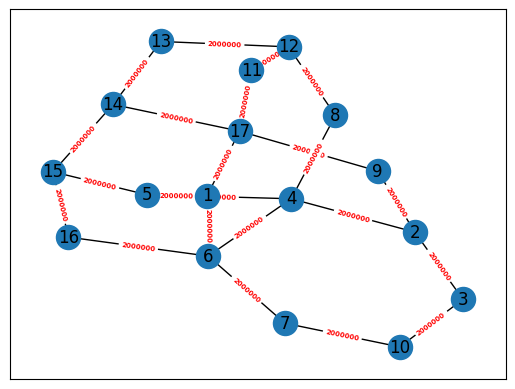

In [51]:
#Draw loaded graph
# spring layout prevents graph from
# becoming too clustered
layout = nx.spring_layout(G)
# draw node, edges, and labels sperately
nx.draw_networkx_labels(G, pos=layout )
nx.draw_networkx_nodes(G, pos=layout) 
nx.draw_networkx_edges(G, pos=layout)
# only add capacities as labels
edge_labels = dict([((source, dest), G[source][dest]["capacity"]) for source, dest in G.edges])
nx.draw_networkx_edge_labels(G, pos= layout, edge_labels= edge_labels,font_color="red", font_weight="bold", font_size = 5)

## Step 3: Parse Traffic Demands

In [ ]:
#TODO

## Step 4: Traffic Algorithm: Maximize Total Throughput


In [ ]:
#TODO

## Step 5: Traffic Algorithm: Maximize Link Utilization

In [ ]:
#TODO

## Step 6: Compare Algorithms

TODO

## Step 7 (EXTRA CREDIT): Scaling with Topology Size